# Generate Upsetplots

In this notebook we will be generating two upsetplots: the first will plot counts of cells based on if they have an entry for the associated annotations, and the second will plot counts of cells based on their values for the associated annotations.

In [27]:
import pymaid
import logging
import pandas as pd
import numpy as np
from itertools import chain, combinations
from upsetplot import plot
from matplotlib import pyplot as plt
from pkg.platy import _get_folder, load_annotations

In [28]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

We import the folder to save our upsetplots and the table of annotations which will help us make our upsetplots

In [29]:
folder = _get_folder()
annotations = load_annotations()
annotations.fillna("N/A", inplace=True)
annotations

,skids,side,class,segment,type,group
0,1343291,rc,N/A,head,N/A,N/A
1,1332516,rc,s,head,49.0,N/A
2,1402724,rc,N/A,3,N/A,N/A
3,1462664,rc,N/A,2,N/A,N/A
4,84457,rc,N/A,head,N/A,N/A
...,...,...,...,...,...,...
9192,2256298,N/A,N/A,1,N/A,N/A
9193,2256326,N/A,N/A,1,N/A,N/A
9194,2256339,N/A,N/A,1,N/A,N/A
9195,1602239,N/A,N/A,1,N/A,N/A


The following function returns a series where the indices are all the skids in the annotations table and the values are if they have a value for the category passed in

In [38]:
#returns boolean pandas series: False if element is "N/A", else True
def has_category(annotations, category="side"):
    has_list = []
    series_name = "has_{}".format(category)
    for val in annotations[category]:
        if val != "N/A":
            has_list.append(True)
        else:
            has_list.append(False)
    return pd.Series(index=annotations["skids"], data=has_list, name=series_name)

In [46]:
#generate boolean pandas series for the different categories
has_categs = {"has_side": None, "has_class": None, "has_segment": None, "has_type": None, "has_group": None}
for key in has_categs:
    has_categs[key] = has_category(annotations, category=key.split("_")[1])

{'has_side': skids
 1343291     True
 1332516     True
 1402724     True
 1462664     True
 84457       True
            ...  
 2256298    False
 2256326    False
 2256339    False
 1602239    False
 2256258    False
 Name: has_side, Length: 9197, dtype: bool,
 'has_class': skids
 1343291    False
 1332516     True
 1402724    False
 1462664    False
 84457      False
            ...  
 2256298    False
 2256326    False
 2256339    False
 1602239    False
 2256258    False
 Name: has_class, Length: 9197, dtype: bool,
 'has_segment': skids
 1343291    True
 1332516    True
 1402724    True
 1462664    True
 84457      True
            ... 
 2256298    True
 2256326    True
 2256339    True
 1602239    True
 2256258    True
 Name: has_segment, Length: 9197, dtype: bool,
 'has_type': skids
 1343291    False
 1332516     True
 1402724    False
 1462664    False
 84457      False
            ...  
 2256298    False
 2256326    False
 2256339    False
 1602239    False
 2256258    False
 Na

With series of booleans for all our categories, we can concatenate our series to make a dataframe, and call `groupby` which will group the dataframe based on the number of cells for each subset of category values (ex: how many cells that have ["has_side"=False, "has_class"=False, "has_segment"=False, "has_type"=False, "has_group"=False] and so on).

In [47]:
bool_ids = list(has_categs.values())

#boolean dataframe from concatenating the boolean series
annotations_bool = pd.concat(bool_ids, axis=1, ignore_index=False, names="ID").fillna(
    "N/A"
)
#group the annotations dataframe by the categories and get the number of cells for each subset of category values
bool_counts = annotations_bool.groupby(bool_ids).size()
print(annotations_bool)
print(bool_counts)

         has_side  has_class  has_segment  has_type  has_group
skids                                                         
1343291      True      False         True     False      False
1332516      True       True         True      True      False
1402724      True      False         True     False      False
1462664      True      False         True     False      False
84457        True      False         True     False      False
...           ...        ...          ...       ...        ...
2256298     False      False         True     False      False
2256326     False      False         True     False      False
2256339     False      False         True     False      False
1602239     False      False         True     False      False
2256258     False      False         True     False      False

[9197 rows x 5 columns]
has_side  has_class  has_segment  has_type  has_group
False     False      True         False     False          25
          True       False        False 

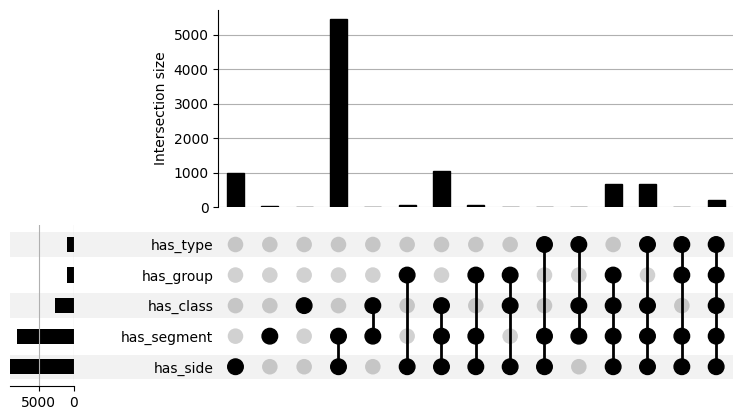

In [48]:
#generate the upsetplot of the grouped dataframe and save it
plot(bool_counts)
plt.savefig(folder / "broad_categs_upsetplot.png")

We start generating the second upsetplot by using the following function, which determines if all the skids have the particular `name` within the particular `category`

In [41]:
#returns boolean pandas series: True if element=name, else False
def has_element(annotations, category="side", name="l"):
    has_element = []
    series_name = "{}_{}".format(category, name)
    for val in annotations[category]:
        if val == name:
            has_element.append(True)
        else:
            has_element.append(False)
    return pd.Series(index=annotations["skids"], data=has_element, name=series_name)

For this upsetplot, we just consider the values that can be passed by the categories `side`, `class` and `segment`, and splice the keys based on the category so we can retrieve the values we want to pass in

In [57]:
#generate boolean pandas series for the different names within their respective category

has_sides = {"has_left": None, "has_right": None, "has_center": None}
for key in has_sides:
    has_sides[key] = has_element(annotations, category="side", name=key.split("_")[1][0])

has_classes = {"has_sensory": None, "has_inter": None, "has_motor": None}
for key in has_classes:
    has_classes[key] = has_element(annotations, category="class", name=key.split("_")[1][0])

has_segments = {"has_seg0": None, "has_seg1": None, "has_seg2": None, "has_seg3": None}
for key in has_segments:
    has_segments[key] = has_element(annotations, category="segment", name=key[-1])

has_hp = {"has_head": None, "has_pygidium": None}
for key in has_hp:
    has_hp[key]= has_element(annotations, category="segment", name=key.split("_")[1])
has_all = has_sides | has_classes | has_segments | has_hp

In [58]:
bool_ids = list(has_all.values())

#boolean dataframe from concatenating the boolean series
annotations_bool = pd.concat(bool_ids, axis=1, ignore_index=False, names="ID").fillna(
    "N/A"
)

#group the annotations dataframe by the names and get the number of cells for each subset of names
bool_counts = annotations_bool.groupby(bool_ids).size()

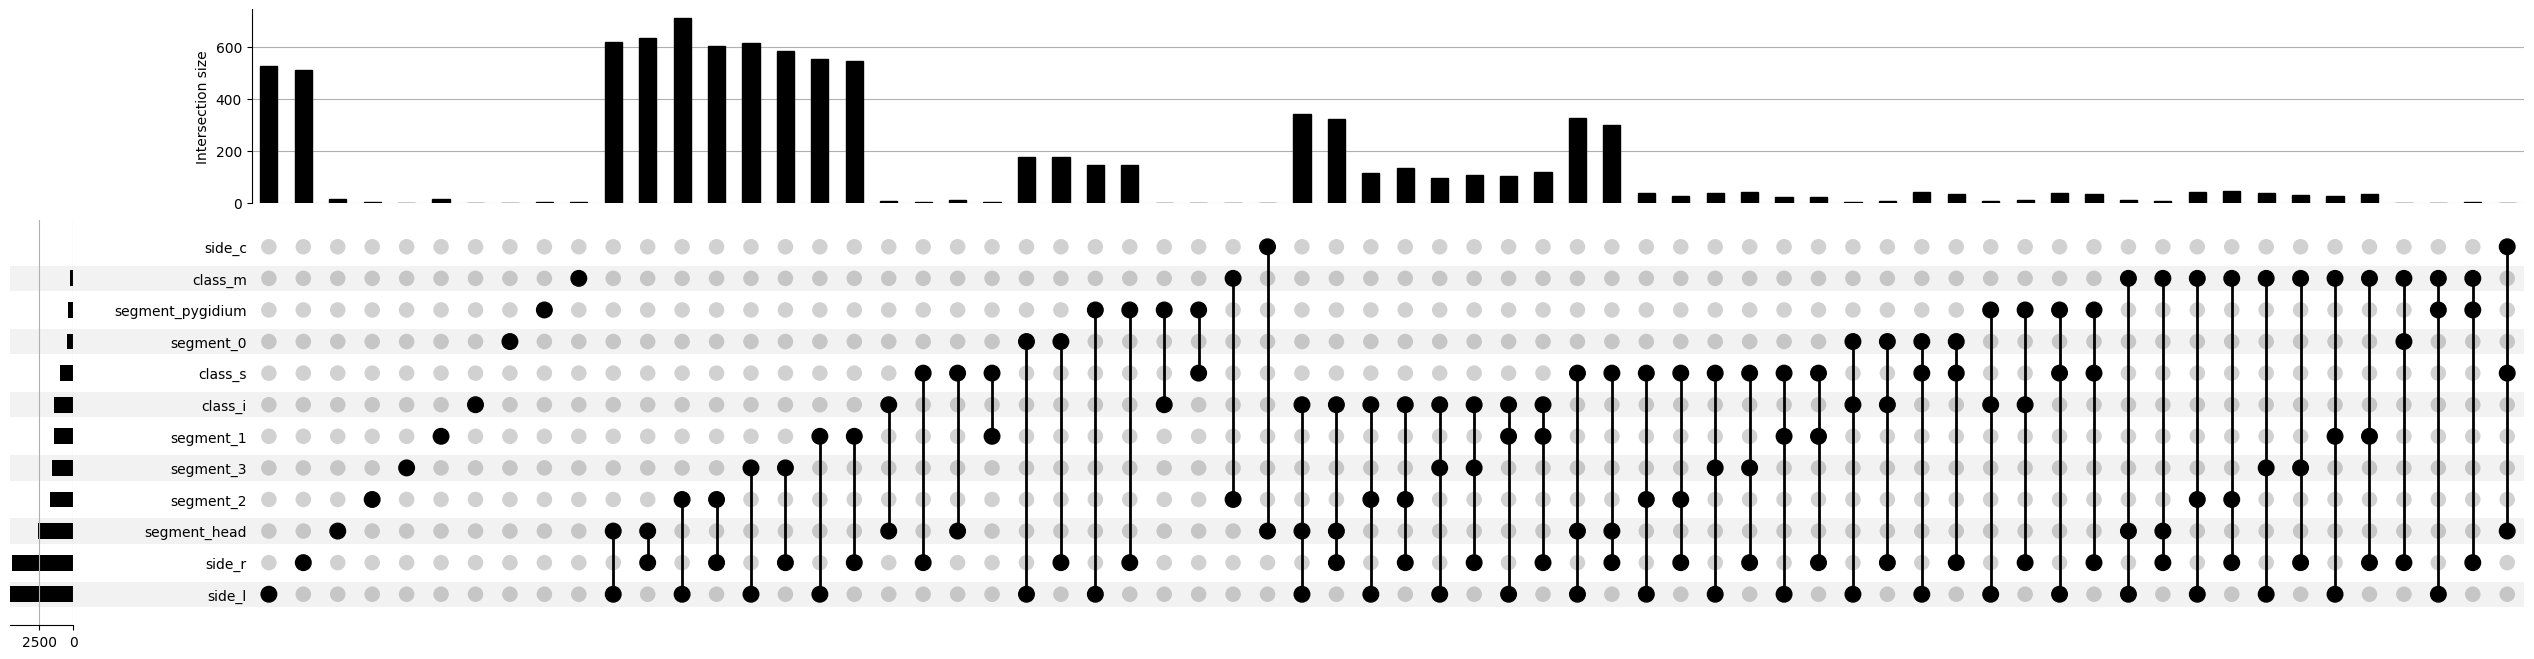

In [59]:
#generate the upsetplot of the grouped dataframe
plot(bool_counts)
plt.savefig(folder / "sub_categs_upsetplot.png")